# House Price Prediction ML Project


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
np.random.seed(42)

n_samples = 1000

data = {
    'bedrooms': np.random.randint(1, 6, n_samples),
    'bathrooms': np.random.randint(1, 5, n_samples),
    'sqft_living': np.random.randint(500, 5000, n_samples),
    'sqft_lot': np.random.randint(1000, 20000, n_samples),
    'floors': np.random.choice([1, 1.5, 2, 2.5, 3], n_samples),
    'waterfront': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
    'view': np.random.randint(0, 5, n_samples),
    'condition': np.random.randint(1, 6, n_samples),
    'grade': np.random.randint(3, 13, n_samples),
    'sqft_above': np.random.randint(400, 4000, n_samples),
    'sqft_basement': np.random.randint(0, 2000, n_samples),
    'yr_built': np.random.randint(1900, 2021, n_samples),
    'yr_renovated': np.random.choice([0] + list(range(1950, 2021)), n_samples, p=[0.7] + [0.3/71]*71),
    'zipcode': np.random.choice([98001, 98002, 98003, 98004, 98005, 98006], n_samples),
    'lat': np.random.uniform(47.15, 47.75, n_samples),
    'long': np.random.uniform(-122.5, -121.3, n_samples)
}
df = pd.DataFrame(data)

price = (
    df['sqft_living'] * 150 +
    df['bedrooms'] * 10000 +
    df['bathrooms'] * 15000 +
    df['waterfront'] * 200000 +
    df['view'] * 20000 +
    df['grade'] * 25000 +
    (2021 - df['yr_built']) * (-500) +
    np.random.normal(0, 50000, n_samples)
)

df['price'] = np.maximum(price, 50000)

print(" Dataset created successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")


 Dataset created successfully!
Dataset shape: (1000, 17)
Price range: $210,455 - $1,426,688


In [3]:
print("DATASET OVERVIEW")
print(df.info())
print("\nDataset Description:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nFirst 5 rows:")
print(df.head())



DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       1000 non-null   int64  
 1   bathrooms      1000 non-null   int64  
 2   sqft_living    1000 non-null   int64  
 3   sqft_lot       1000 non-null   int64  
 4   floors         1000 non-null   float64
 5   waterfront     1000 non-null   int64  
 6   view           1000 non-null   int64  
 7   condition      1000 non-null   int64  
 8   grade          1000 non-null   int64  
 9   sqft_above     1000 non-null   int64  
 10  sqft_basement  1000 non-null   int64  
 11  yr_built       1000 non-null   int64  
 12  yr_renovated   1000 non-null   int64  
 13  zipcode        1000 non-null   int64  
 14  lat            1000 non-null   float64
 15  long           1000 non-null   float64
 16  price          1000 non-null   float64
dtypes: float64(4), int64(13)
memory usag

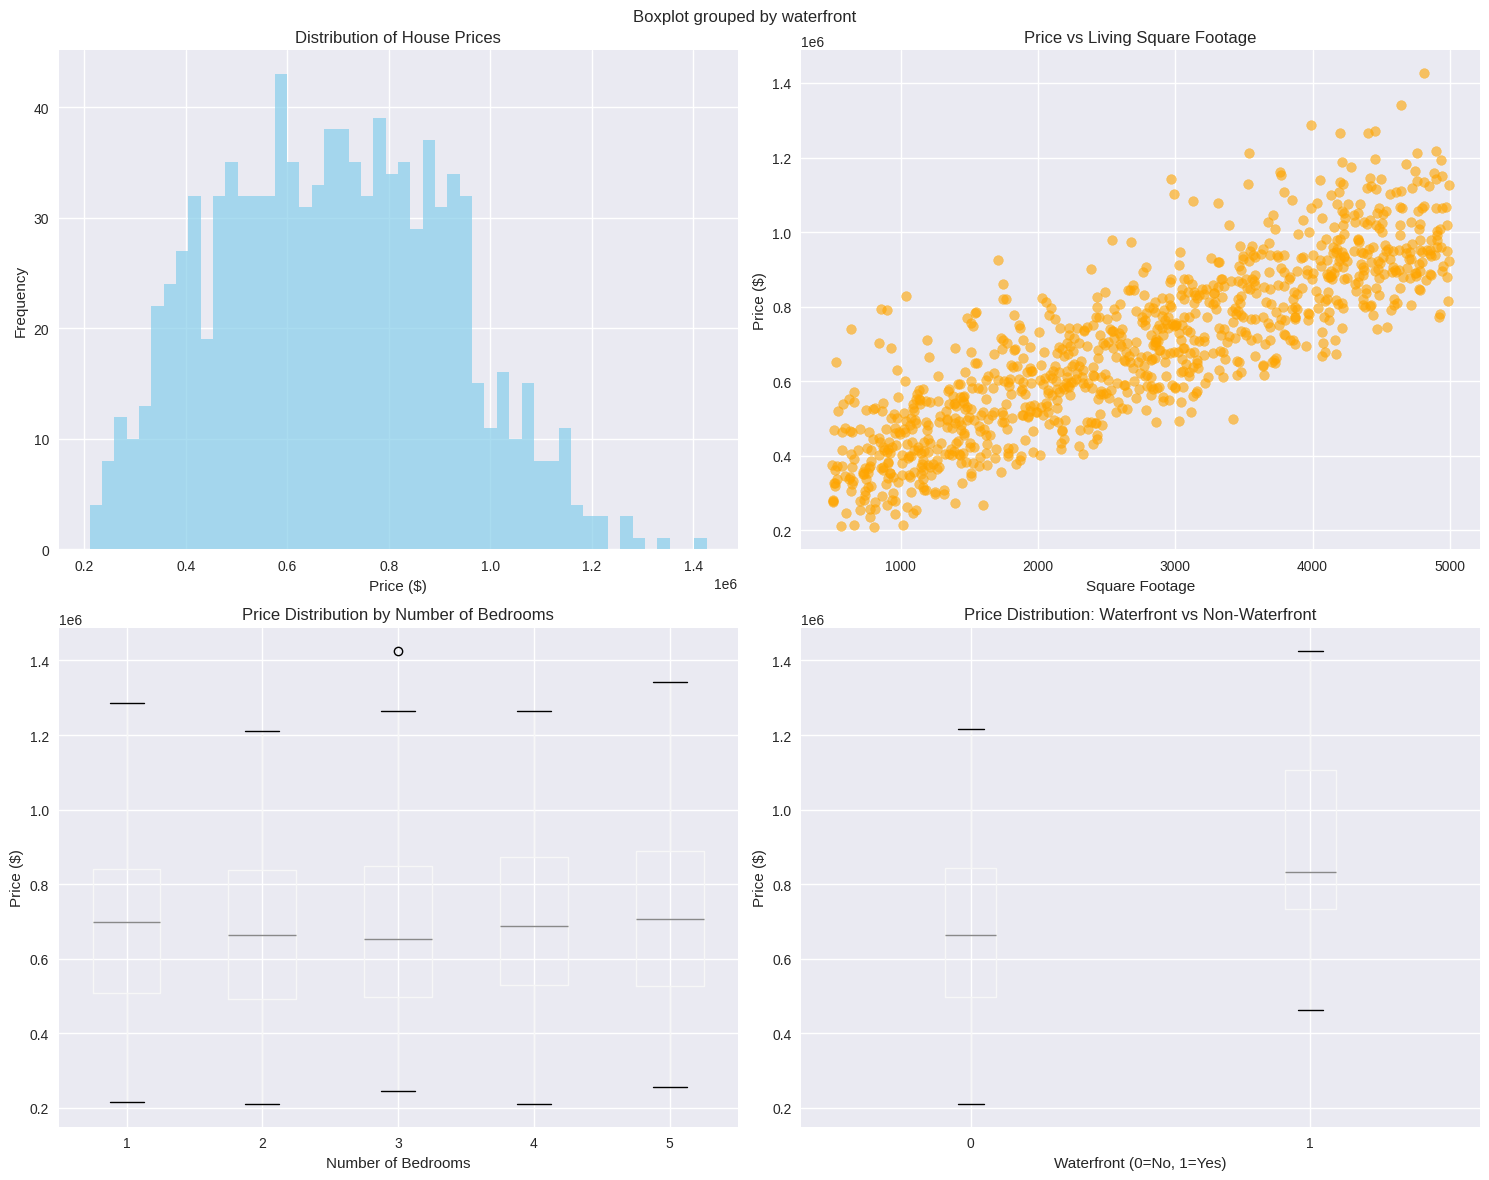

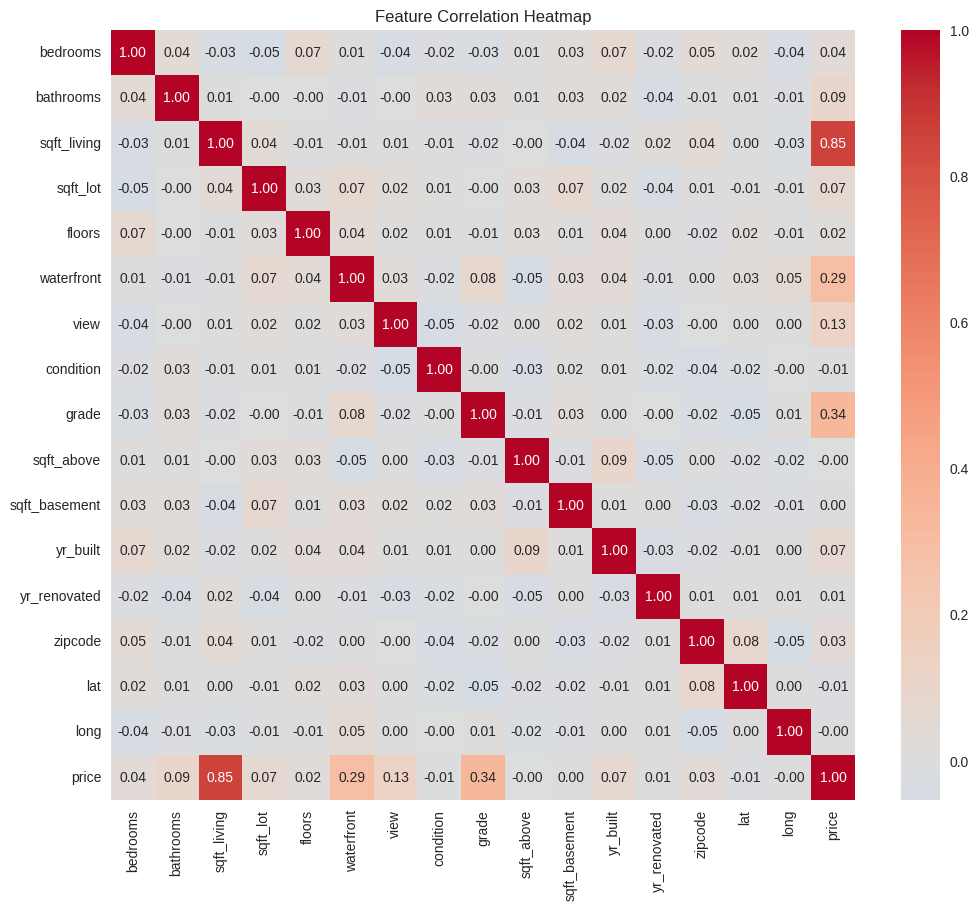

 Data visualization completed!


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(df['price'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of House Prices')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].scatter(df['sqft_living'], df['price'], alpha=0.6, color='orange')
axes[0, 1].set_title('Price vs Living Square Footage')
axes[0, 1].set_xlabel('Square Footage')
axes[0, 1].set_ylabel('Price ($)')

df.boxplot(column='price', by='bedrooms', ax=axes[1, 0])
axes[1, 0].set_title('Price Distribution by Number of Bedrooms')
axes[1, 0].set_xlabel('Number of Bedrooms')
axes[1, 0].set_ylabel('Price ($)')

df.boxplot(column='price', by='waterfront', ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution: Waterfront vs Non-Waterfront')
axes[1, 1].set_xlabel('Waterfront (0=No, 1=Yes)')
axes[1, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

print(" Data visualization completed!")



In [5]:
df_processed = df.copy()
df_processed['house_age'] = 2021 - df_processed['yr_built']
df_processed['renovated'] = (df_processed['yr_renovated'] > 0).astype(int)
df_processed['price_per_sqft'] = df_processed['price'] / df_processed['sqft_living']

imputer = SimpleImputer(strategy='median')
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
df_processed[numeric_columns] = imputer.fit_transform(df_processed[numeric_columns])

features_to_use = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_above',
    'sqft_basement', 'house_age', 'renovated', 'lat', 'long'
]

X = df_processed[features_to_use]
y = df_processed['price']

print(" Data preprocessing completed!")
print(f"Features used: {len(features_to_use)}")
print(f"Feature names: {features_to_use}")



 Data preprocessing completed!
Features used: 15
Feature names: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'house_age', 'renovated', 'lat', 'long']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Data split and scaling completed!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


 Data split and scaling completed!
Training set size: 800 samples
Test set size: 200 samples


Model Training


In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

print(" Model training completed!")



Training Linear Regression...

Training Random Forest...
 Model training completed!


MODEL PERFORMANCE COMPARISON
            Model     RMSE      MAE  R² Score
Linear Regression 51136.99 41180.24      0.96
    Random Forest 69236.72 56756.02      0.92


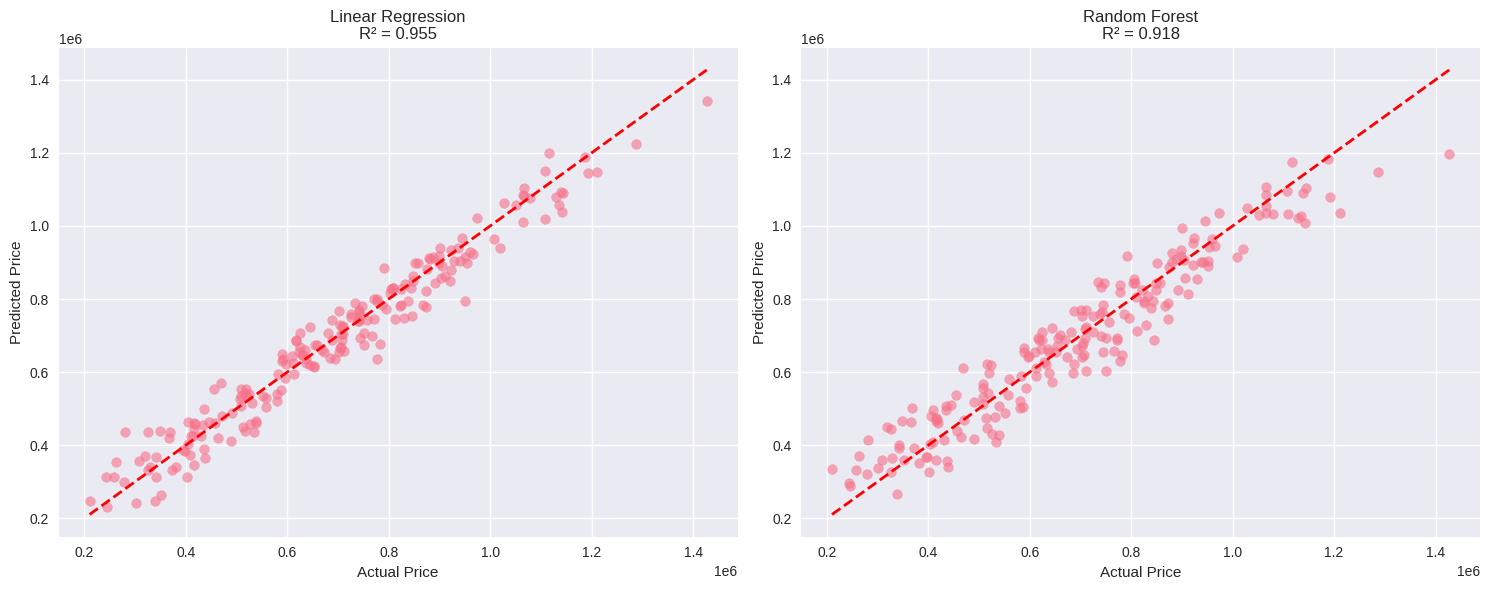

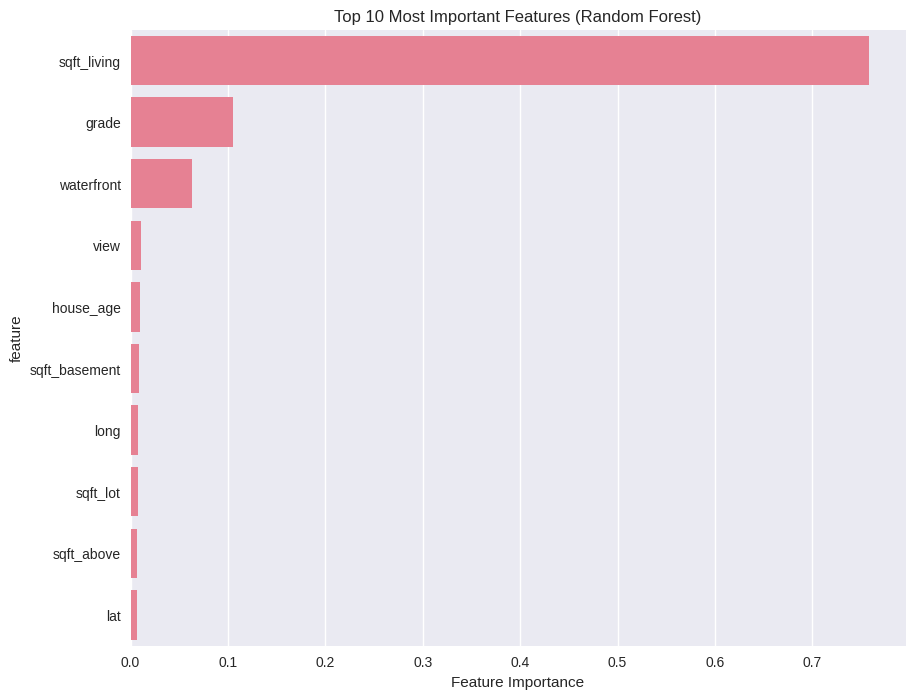


Top 10 Most Important Features:
      feature  importance
  sqft_living    0.757836
        grade    0.105202
   waterfront    0.062763
         view    0.010528
    house_age    0.010126
sqft_basement    0.008518
         long    0.007658
     sqft_lot    0.007242
   sqft_above    0.006616
          lat    0.006561


In [8]:
print("MODEL PERFORMANCE COMPARISON")
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [results['rmse'] for results in model_results.values()],
    'MAE': [results['mae'] for results in model_results.values()],
    'R² Score': [results['r2'] for results in model_results.values()]
})

print(results_df.to_string(index=False, float_format='%.2f'))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, results) in enumerate(model_results.items()):
    axes[i].scatter(y_test, results['predictions'], alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')
    axes[i].set_title(f'{name}\nR² = {results["r2"]:.3f}')

plt.tight_layout()
plt.show()

rf_model = model_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': features_to_use,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))



Sample Predictions


In [9]:

sample_houses = pd.DataFrame({
    'bedrooms': [3, 4, 2],
    'bathrooms': [2, 3, 1],
    'sqft_living': [1800, 2500, 1200],
    'sqft_lot': [7000, 9000, 5000],
    'floors': [1.5, 2, 1],
    'waterfront': [0, 1, 0],
    'view': [2, 4, 1],
    'condition': [4, 5, 3],
    'grade': [7, 9, 6],
    'sqft_above': [1800, 2200, 1200],
    'sqft_basement': [0, 300, 0],
    'house_age': [20, 15, 30],
    'renovated': [0, 1, 0],
    'lat': [47.5, 47.6, 47.4],
    'long': [-122.2, -122.1, -122.3]
})

best_model = model_results['Random Forest']['model']
sample_predictions = best_model.predict(sample_houses)

print("SAMPLE PREDICTIONS")

for i, pred in enumerate(sample_predictions):
    print(f"House {i+1}: ${pred:,.0f}")
    print(f"  - {sample_houses.iloc[i]['bedrooms']} bed, {sample_houses.iloc[i]['bathrooms']} bath")
    print(f"  - {sample_houses.iloc[i]['sqft_living']} sqft")
    print(f"  - Waterfront: {'Yes' if sample_houses.iloc[i]['waterfront'] else 'No'}")
    print()



SAMPLE PREDICTIONS
House 1: $493,645
  - 3.0 bed, 2.0 bath
  - 1800.0 sqft
  - Waterfront: No

House 2: $883,952
  - 4.0 bed, 3.0 bath
  - 2500.0 sqft
  - Waterfront: Yes

House 3: $348,811
  - 2.0 bed, 1.0 bath
  - 1200.0 sqft
  - Waterfront: No



 Model Saving


In [10]:

# import joblib
# joblib.dump(best_model, 'house_price_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')

print("PROJECT SUMMARY")
print(f" Dataset: {df.shape[0]} houses with {df.shape[1]} features")
print(f" Best Model: Random Forest Regressor")
print(f" Best R² Score: {model_results['Random Forest']['r2']:.3f}")
print(f" Best RMSE: ${model_results['Random Forest']['rmse']:,.0f}")
print(f" Model can explain {model_results['Random Forest']['r2']*100:.1f}% of price variation")


PROJECT SUMMARY
 Dataset: 1000 houses with 17 features
 Best Model: Random Forest Regressor
 Best R² Score: 0.918
 Best RMSE: $69,237
 Model can explain 91.8% of price variation
